In [2]:
import sys
from pathlib import Path

repo_root = Path("../..").resolve()
src_dir = str(repo_root / "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import jax.numpy as jnp

from compressible_core import chemistry_utils, energy_models
from compressible_2d import (
    mesh_gmsh,
    equation_manager_types,
    equation_manager_utils,
    numerics_types,
)

### setup

In [3]:
# Load mesh and solution
repo_root = Path("/home/hhoechter/jaxfluids_internship")
data_dir = repo_root / "data"

mesh = mesh_gmsh.read_gmsh_v2_wedge_plane(
    str(data_dir / "bluntedCone.msh"),
    wedge_plane_tag=4,
    remap_tags={7: 7},
    axis_tag=7,
)
sol = np.load(str(repo_root / "experiments/blunt_cone_2d/solution_1e-11_t1e-5.npz"))
U_hist = sol["U"]
t_hist = sol["t"]
print(f"U shape: {U_hist.shape}, t: {t_hist}")
print(f"Mesh cells: {mesh.cell_areas.shape[0]}")

# Build a minimal equation manager for extract_primitives
species_names = ("N2",)
energy_cfg = energy_models.EnergyModelConfig(
    model="bird",
    include_electronic=False,
    data_path=str(data_dir / "air_5_bird_energy.json"),
)
species = chemistry_utils.load_species_table(
    species_names=species_names,
    general_data_path=str(data_dir / "species.json"),
    energy_model_config=energy_cfg,
)

boundary_tags = np.unique(mesh.boundary_tags)
tag_to_bc = {int(tag): {"type": "outflow"} for tag in boundary_tags if tag >= 0}

boundary_config = equation_manager_types.BoundaryConditionConfig2D(tag_to_bc=tag_to_bc)

numerics_config = numerics_types.NumericsConfig2D(
    dt=1e-9,
    cfl=0.4,
    dt_mode="fixed",
    integrator_scheme="rk2",
    spatial_scheme="first_order",
    flux_scheme="hllc",
    axisymmetric=True,
    clipping=numerics_types.ClippingConfig2D(),
)

eq_manager = equation_manager_utils.build_equation_manager(
    mesh,
    species=species,
    collision_integrals=None,
    reactions=None,
    numerics_config=numerics_config,
    boundary_config=boundary_config,
    transport_model=None,
    casseau_transport=None,
)

U shape: (2001, 120000, 5), t: [0.00000000e+00 4.99999997e-09 9.99999994e-09 ... 9.99436907e-06
 9.99937129e-06 1.00043735e-05]
Mesh cells: 120000


In [4]:
import jax

# Build triangulation (shared across all time steps)
triangles_i, triangles_j, triangles_k = [], [], []
for cell_nodes in mesh.cells:
    n = len(cell_nodes)
    if n == 3:
        triangles_i += [cell_nodes[0]]
        triangles_j += [cell_nodes[1]]
        triangles_k += [cell_nodes[2]]
    elif n == 4:
        triangles_i += [cell_nodes[0], cell_nodes[0]]
        triangles_j += [cell_nodes[1], cell_nodes[2]]
        triangles_k += [cell_nodes[2], cell_nodes[3]]

triangles = np.column_stack(
    [np.array(triangles_i), np.array(triangles_j), np.array(triangles_k)]
)
nodes_x = np.array(mesh.nodes[:, 0])
nodes_y = np.array(mesh.nodes[:, 1])
print(f"n_cells={len(mesh.cells)}, n_triangles={len(triangles)}")


def cell_to_tri_vals(cell_values):
    """Map cell-centered values to per-triangle values (quads produce 2 triangles)."""
    tri_vals = []
    for cell_idx, cell_nodes in enumerate(mesh.cells):
        tri_vals.append(cell_values[cell_idx])
        if len(cell_nodes) == 4:
            tri_vals.append(cell_values[cell_idx])
    return np.array(tri_vals)


_extract_all = jax.jit(
    jax.vmap(lambda U: equation_manager_utils.extract_primitives_from_U(U, eq_manager))
)
Y_s_all, rho_all, u_all, v_all, T_all, Tv_all, p_all = _extract_all(jnp.array(U_hist))

n_cells=120000, n_triangles=240000


2026-02-25 13:44:38.838087: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 5.45GiB (5853974730 bytes) by rematerialization; only reduced to 10.96GiB (11767392852 bytes), down from 10.96GiB (11767392852 bytes) originally


### plot t x primitives

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

triang = mtri.Triangulation(nodes_x, nodes_y, triangles)
primitive_names = list(all_primitives[0].keys())
n_prims = len(primitive_names)
n_cols = len(all_primitives)

fig, axes = plt.subplots(n_prims, n_cols, figsize=(3.5 * n_cols, 3.0 * n_prims))

for row, name in enumerate(primitive_names):
    all_vals = np.concatenate(
        [cell_to_tri_vals(all_primitives[col][name]) for col in range(n_cols)]
    )
    finite = all_vals[np.isfinite(all_vals)]
    vmin = np.percentile(finite, 1) if len(finite) else 0.0
    vmax = np.percentile(finite, 99) if len(finite) else 1.0

    for col in range(n_cols):
        ax = axes[row, col]
        tri_vals = cell_to_tri_vals(all_primitives[col][name])
        tc = ax.tripcolor(
            triang,
            facecolors=tri_vals,
            cmap="plasma",
            shading="flat",
            vmin=vmin,
            vmax=vmax,
        )
        if row == 0:
            ax.set_title(f"t = {float(t_hist[col]):.2e} s", fontsize=9)
        if col == 0:
            ax.set_ylabel(name, fontsize=9)
        ax.set_aspect("equal")
        ax.tick_params(labelsize=7)
        if col == n_cols - 1:
            fig.colorbar(tc, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(
    "Primitive variables — rows: variable, columns: time step", fontsize=11, y=1.01
)
plt.tight_layout()
plt.show()

### plot t= primitives

n_cells=120000, n_nodes=241401, n_triangles=240000
t_last = 1.000e-05 s


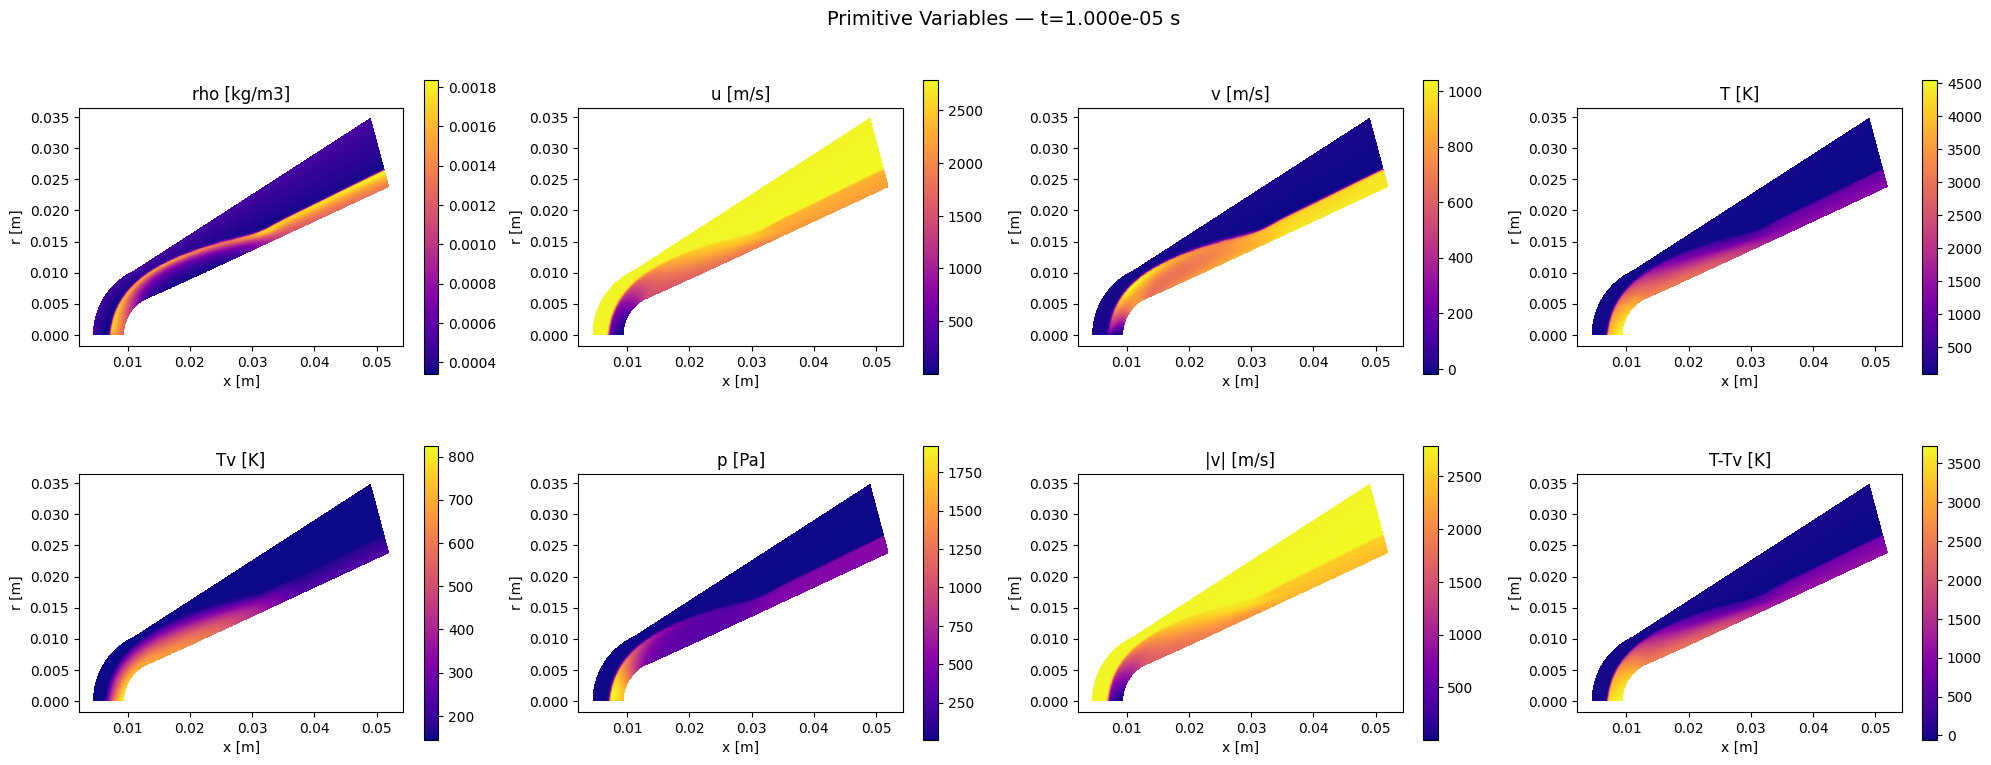

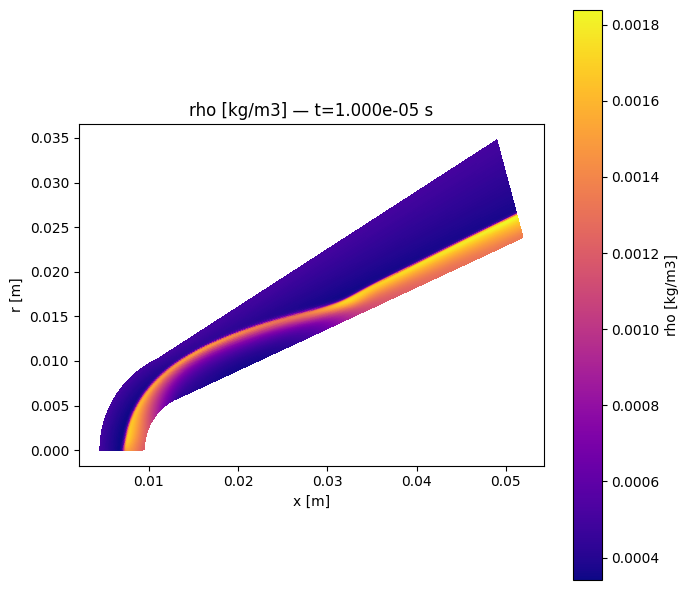

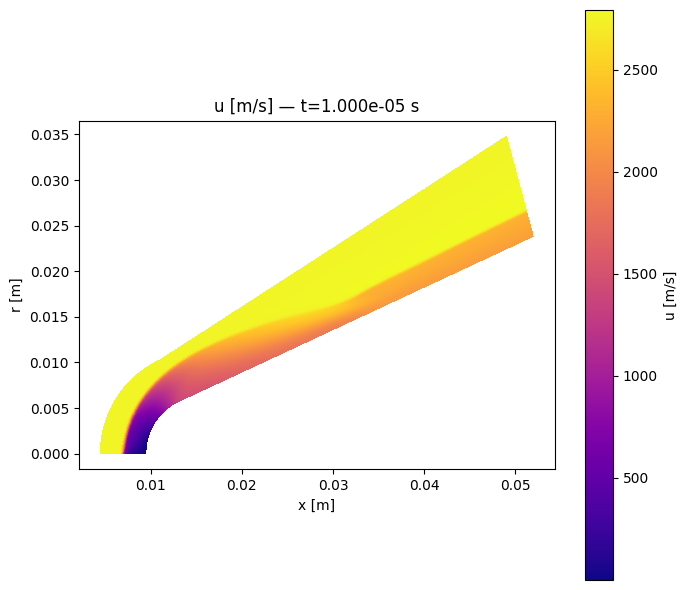

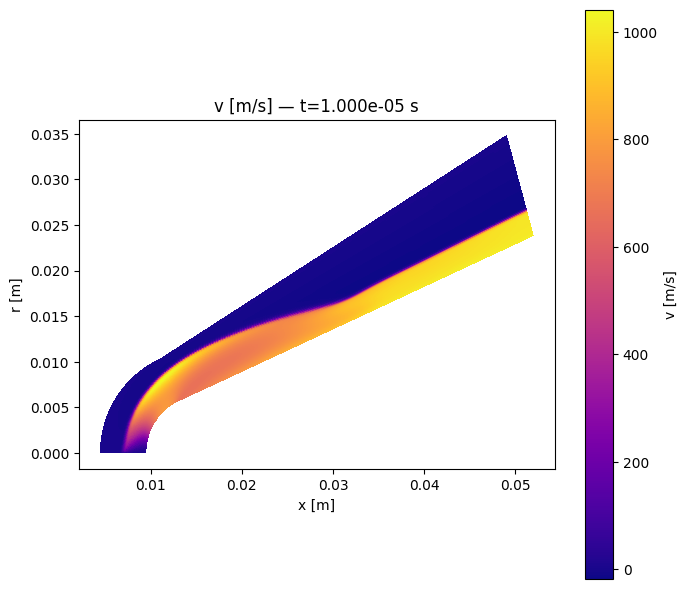

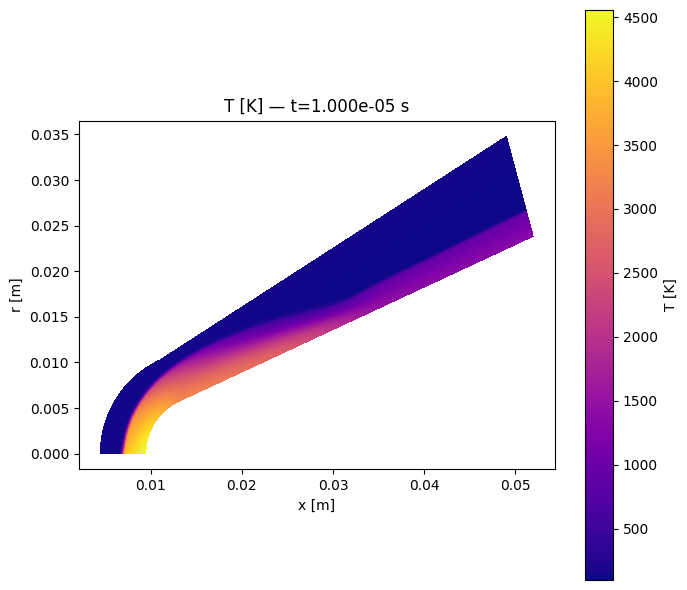

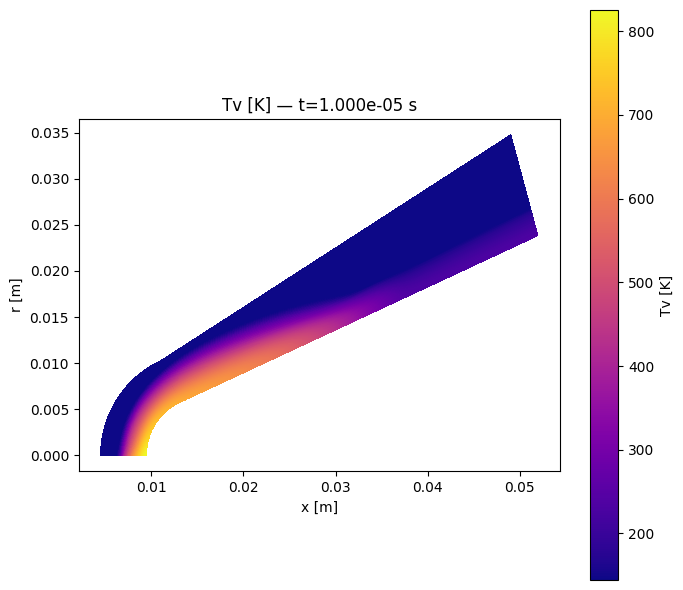

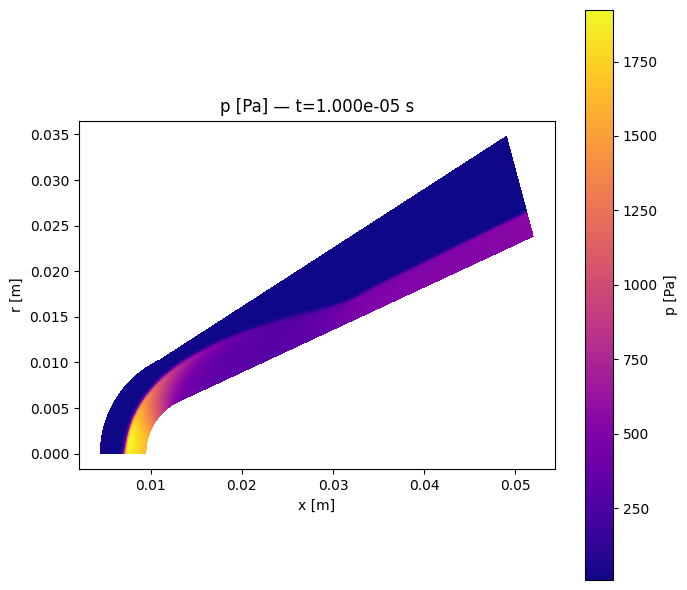

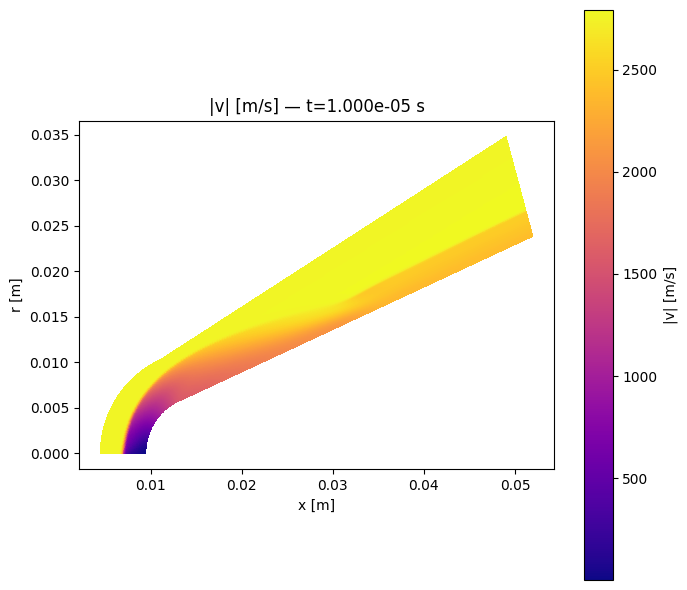

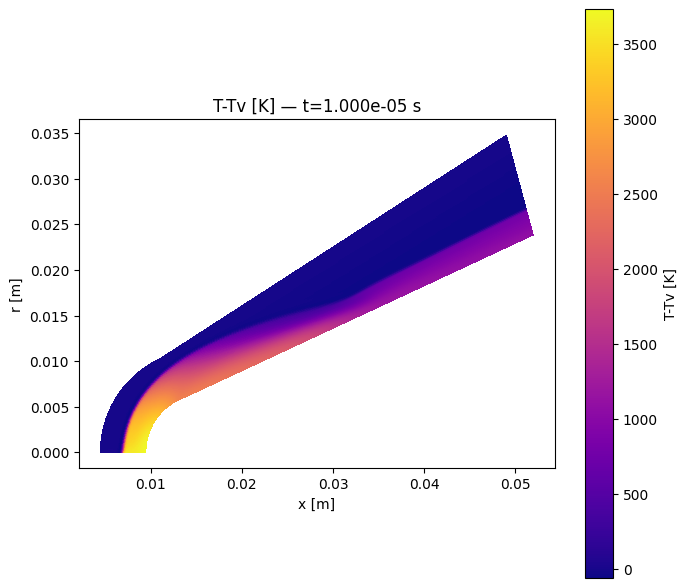

In [10]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# Extract primitives at last timestep
U_last = U_hist[-1]
Y_s, rho, u, v, T, Tv, p = equation_manager_utils.extract_primitives_from_U(
    U_last, eq_manager
)

nodes_x = np.array(mesh.nodes[:, 0])
nodes_y = np.array(mesh.nodes[:, 1])

# Build triangulation (split quads into two triangles)
tri_i, tri_j, tri_k = [], [], []
for cell_nodes in mesh.cells:
    n = len(cell_nodes)
    if n == 3:
        tri_i.append(cell_nodes[0])
        tri_j.append(cell_nodes[1])
        tri_k.append(cell_nodes[2])
    elif n == 4:
        tri_i += [cell_nodes[0], cell_nodes[0]]
        tri_j += [cell_nodes[1], cell_nodes[2]]
        tri_k += [cell_nodes[2], cell_nodes[3]]

triang = mtri.Triangulation(nodes_x, nodes_y, np.column_stack([tri_i, tri_j, tri_k]))

print(
    f"n_cells={len(mesh.cells)}, n_nodes={mesh.nodes.shape[0]}, n_triangles={len(tri_i)}"
)
print(f"t_last = {float(t_hist[-1]):.3e} s")

primitives = {
    "rho [kg/m3]": np.array(rho),
    "u [m/s]": np.array(u),
    "v [m/s]": np.array(v),
    "T [K]": np.array(T),
    "Tv [K]": np.array(Tv),
    "p [Pa]": np.array(p),
    "|v| [m/s]": np.sqrt(np.array(u) ** 2 + np.array(v) ** 2),
    "T-Tv [K]": np.array(T) - np.array(Tv),
}


def cell_to_triangle_values(cell_values):
    tri_vals = []
    for cell_idx, cell_nodes in enumerate(mesh.cells):
        tri_vals.append(cell_values[cell_idx])
        if len(cell_nodes) == 4:
            tri_vals.append(cell_values[cell_idx])
    return np.array(tri_vals)


t_str = f"t={float(t_hist[-1]):.3e} s"

# --- grid overview ---
n_cols = 4
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, (name, values) in enumerate(primitives.items()):
    ax = axes[idx]
    tri_vals = cell_to_triangle_values(values)
    tc = ax.tripcolor(triang, facecolors=tri_vals, cmap="plasma", shading="flat")
    fig.colorbar(tc, ax=ax, shrink=0.8)
    ax.set_title(name)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("r [m]")
    ax.set_aspect("equal")

for ax in axes[len(primitives) :]:
    ax.set_visible(False)

fig.suptitle(f"Primitive Variables — {t_str}", fontsize=14)
plt.tight_layout()
plt.show()

# --- individual plots ---
for name, values in primitives.items():
    fig, ax = plt.subplots(figsize=(7, 6))
    tri_vals = cell_to_triangle_values(values)
    tc = ax.tripcolor(triang, facecolors=tri_vals, cmap="plasma", shading="flat")
    fig.colorbar(tc, ax=ax, label=name)
    ax.set_title(f"{name} — {t_str}")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("r [m]")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

### velocity quiver

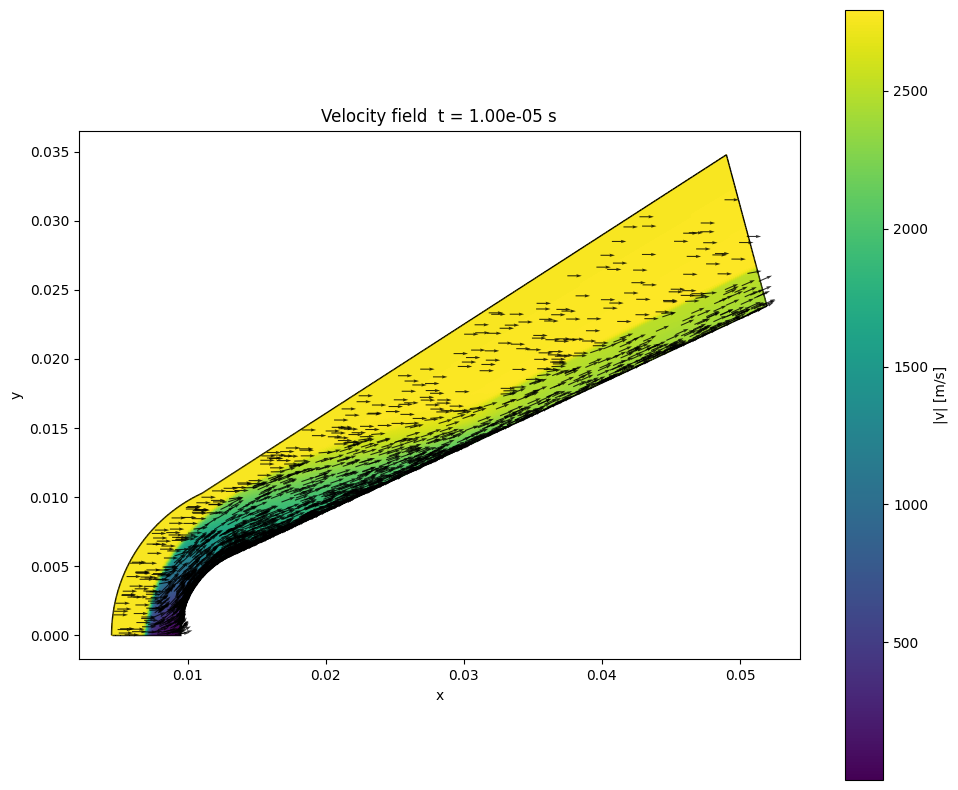

In [8]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.tri as mtri

triang = mtri.Triangulation(nodes_x, nodes_y, triangles)

step = -1  # change to inspect other time steps

u_vals = all_primitives[step]["u [m/s]"]
v_vals = all_primitives[step]["v [m/s]"]
speed = np.sqrt(u_vals**2 + v_vals**2)

cx = mesh.cell_centroids[:, 0]
cy = mesh.cell_centroids[:, 1]

rng = np.random.default_rng(0)
idx = rng.choice(len(cx), size=2000, replace=False)

s = speed[idx] + 1e-30
u_norm = u_vals[idx] / s
v_norm = v_vals[idx] / s

fig, ax = plt.subplots(figsize=(10, 8))

tc = ax.tripcolor(
    triang, facecolors=cell_to_tri_vals(speed), cmap="viridis", shading="flat"
)
fig.colorbar(tc, ax=ax, label="|v| [m/s]")

ax.quiver(
    cx[idx],
    cy[idx],
    u_norm,
    v_norm,
    color="black",
    angles="xy",
    scale=50,
    width=1.5e-3,
    headwidth=3,
    alpha=0.8,
)

boundary_segs = [
    [mesh.nodes[mesh.face_nodes[fi, 0]], mesh.nodes[mesh.face_nodes[fi, 1]]]
    for fi in np.where(mesh.face_right == -1)[0]
]
ax.add_collection(mc.LineCollection(boundary_segs, colors="black", linewidths=1.0))

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Velocity field  t = {float(t_hist[step]):.2e} s")
plt.tight_layout()
plt.show()

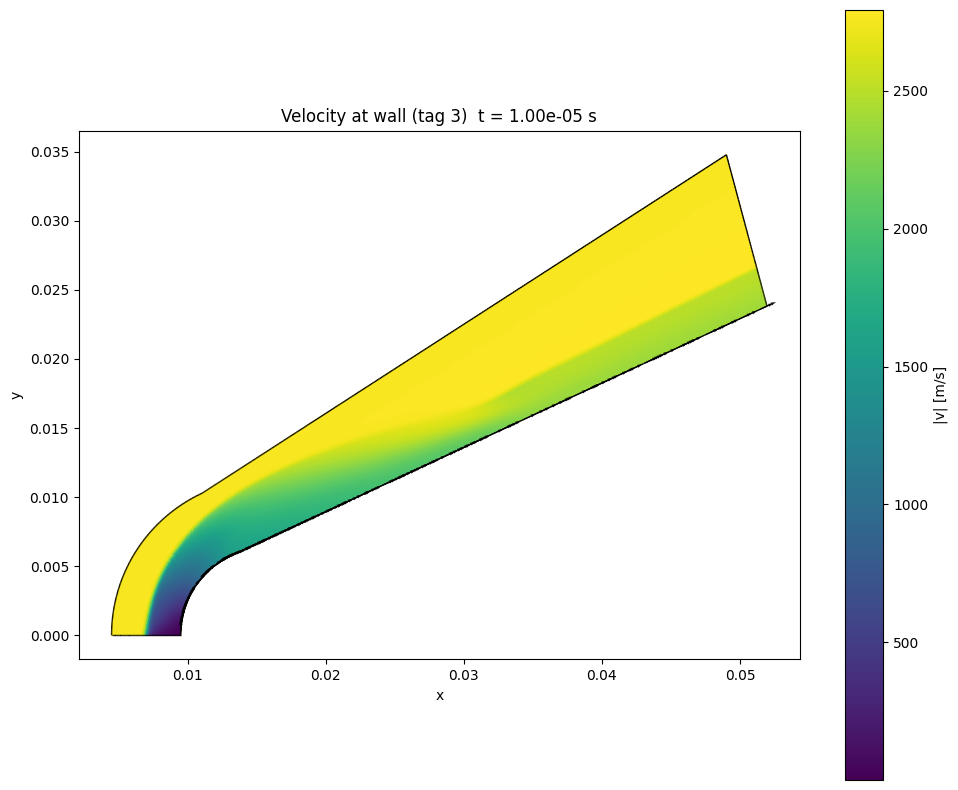

In [9]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc

step = -1  # change to inspect other time steps

u_vals = all_primitives[step]["u [m/s]"]
v_vals = all_primitives[step]["v [m/s]"]
speed = np.sqrt(u_vals**2 + v_vals**2)

# Tag-3 faces: position at face centroid, velocity from adjacent cell (face_left)
tag3_fi = np.where((mesh.face_right == -1) & (mesh.boundary_tags == 3))[0]
# Subsample tag-3 faces
rng = np.random.default_rng(0)
tag3_fi = rng.choice(tag3_fi, size=min(200, len(tag3_fi)), replace=False)
tag3_cx = mesh.face_centroids[tag3_fi, 0]
tag3_cy = mesh.face_centroids[tag3_fi, 1]
tag3_cells = mesh.face_left[tag3_fi]
tag3_u = u_vals[tag3_cells]
tag3_v = v_vals[tag3_cells]
tag3_spd = speed[tag3_cells]

s = tag3_spd + 1e-30
u_norm = tag3_u / s
v_norm = tag3_v / s

fig, ax = plt.subplots(figsize=(10, 8))

tc = ax.tripcolor(
    triang, facecolors=cell_to_tri_vals(speed), cmap="viridis", shading="flat"
)
fig.colorbar(tc, ax=ax, label="|v| [m/s]")

ax.quiver(
    tag3_cx,
    tag3_cy,
    u_norm,
    v_norm,
    color="black",
    angles="xy",
    scale=50,
    width=1.5e-3,
    headwidth=3,
    alpha=0.9,
)

boundary_segs = [
    [mesh.nodes[mesh.face_nodes[fi, 0]], mesh.nodes[mesh.face_nodes[fi, 1]]]
    for fi in np.where(mesh.face_right == -1)[0]
]
ax.add_collection(mc.LineCollection(boundary_segs, colors="black", linewidths=1.0))

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Velocity at wall (tag 3)  t = {float(t_hist[step]):.2e} s")
plt.tight_layout()
plt.show()

### primitives along lines

In [5]:
from scipy.spatial import KDTree


def sample_line(centroids, p0, p1, n_points=400):
    """
    Sample n_points along segment p0→p1, find the nearest cell centroid for each,
    and return (cell_indices, arc_lengths) deduplicated and sorted by arc length.
    """
    p0, p1 = np.array(p0, dtype=float), np.array(p1, dtype=float)
    ts = np.linspace(0.0, 1.0, n_points)
    pts = p0 + ts[:, None] * (p1 - p0)
    _, idxs = KDTree(centroids).query(pts)
    L = float(np.linalg.norm(p1 - p0))
    seen = {}
    for ci, s in zip(idxs.tolist(), (ts * L).tolist()):
        if ci not in seen:
            seen[ci] = s
    cells = np.array(list(seen.keys()))
    arcs = np.array(list(seen.values()))
    order = np.argsort(arcs)
    return cells[order], arcs[order]


cc = mesh.cell_centroids  # (n_cells, 2)
_bfi = {
    tag: np.where((mesh.face_right == -1) & (mesh.boundary_tags == tag))[0]
    for tag in (1, 2, 3, 7)
}  # 1=inflow, 2=outflow, 3=wall, 7=axis

# Identify radial dimension: axis faces (tag 7) have near-zero radial coordinate.
axis_fc = mesh.face_centroids[_bfi[7]]
radial_dim = int(np.argmin(np.abs(axis_fc).mean(axis=0)))
axial_dim = 1 - radial_dim

print(
    f"axial_dim={axial_dim} (col {axial_dim}), radial_dim={radial_dim} (col {radial_dim})"
)
print(
    f"  axis face centroids: col{axial_dim} ∈ [{axis_fc[:, axial_dim].min():.3e}, {axis_fc[:, axial_dim].max():.3e}]"
)
print(
    f"                       col{radial_dim} ∈ [{axis_fc[:, radial_dim].min():.3e}, {axis_fc[:, radial_dim].max():.3e}]"
)

# Stagnation point = wall face centroid closest to the axis (minimum radial coord).
wall_fc = mesh.face_centroids[_bfi[3]]
stag_idx = np.argmin(np.abs(wall_fc[:, radial_dim]))
stag_pt = wall_fc[stag_idx].copy()

# Outer end = inflow face closest to the axis (minimum radial coord).
# This is where the stagnation line meets the inflow boundary at r ≈ 0.
inflow_fc = mesh.face_centroids[_bfi[1]]
outer_idx = np.argmin(np.abs(inflow_fc[:, radial_dim]))
outer_pt = inflow_fc[outer_idx].copy()

print(f"\nStagnation point : {stag_pt}")
print(f"Outer point      : {outer_pt}")

# -----------------------------------------------------------------------
# Define probe lines here — each dict needs 'label', 'p0', 'p1'.
# p0 / p1 are (col0, col1) coordinates in metres.
# -----------------------------------------------------------------------
probe_lines = [
    {"label": "stagnation line (r=0)", "p0": stag_pt, "p1": outer_pt},
]

axial_dim=0 (col 0), radial_dim=1 (col 1)
  axis face centroids: col0 ∈ [4.550e-03, 9.499e-03]
                       col1 ∈ [0.000e+00, 0.000e+00]

Stagnation point : [9.50005373e-03 1.84600448e-05]
Outer point      : [4.50009604e-03 3.29955132e-05]


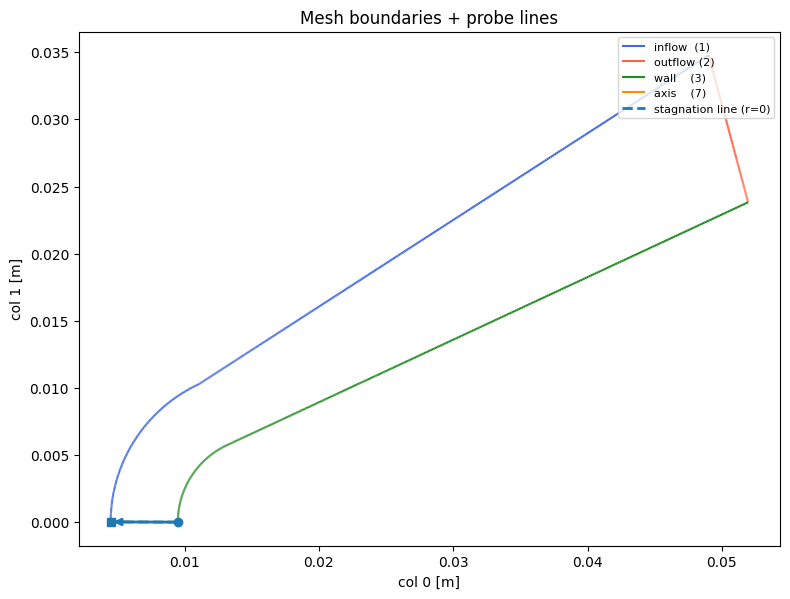

In [6]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc

tag_style = {
    1: dict(color="royalblue", label="inflow  (1)"),
    2: dict(color="tomato", label="outflow (2)"),
    3: dict(color="forestgreen", label="wall    (3)"),
    7: dict(color="darkorange", label="axis    (7)"),
}

fig, ax = plt.subplots(figsize=(8, 7))

# Draw boundary edges grouped by tag
for tag, style in tag_style.items():
    fi = _bfi[tag]
    segs = [
        [mesh.nodes[mesh.face_nodes[f, 0]], mesh.nodes[mesh.face_nodes[f, 1]]]
        for f in fi
    ]
    ax.add_collection(
        mc.LineCollection(
            segs, colors=style["color"], linewidths=1.5, label=style["label"]
        )
    )

# Draw probe lines
line_colors = [plt.cm.tab10(i) for i in range(len(probe_lines))]
for line_def, color in zip(probe_lines, line_colors):
    p0, p1 = np.array(line_def["p0"]), np.array(line_def["p1"])
    ax.annotate(
        "",
        xy=p1,
        xytext=p0,
        arrowprops=dict(arrowstyle="-|>", color=color, lw=2.0),
    )
    ax.plot(
        [p0[0], p1[0]],
        [p0[1], p1[1]],
        color=color,
        lw=2.0,
        ls="--",
        label=line_def["label"],
    )
    ax.plot(*p0, "o", color=color, ms=6)
    ax.plot(*p1, "s", color=color, ms=6)

ax.autoscale_view()
ax.set_aspect("equal")
ax.set_xlabel("col 0 [m]")
ax.set_ylabel("col 1 [m]")
ax.set_title("Mesh boundaries + probe lines")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()

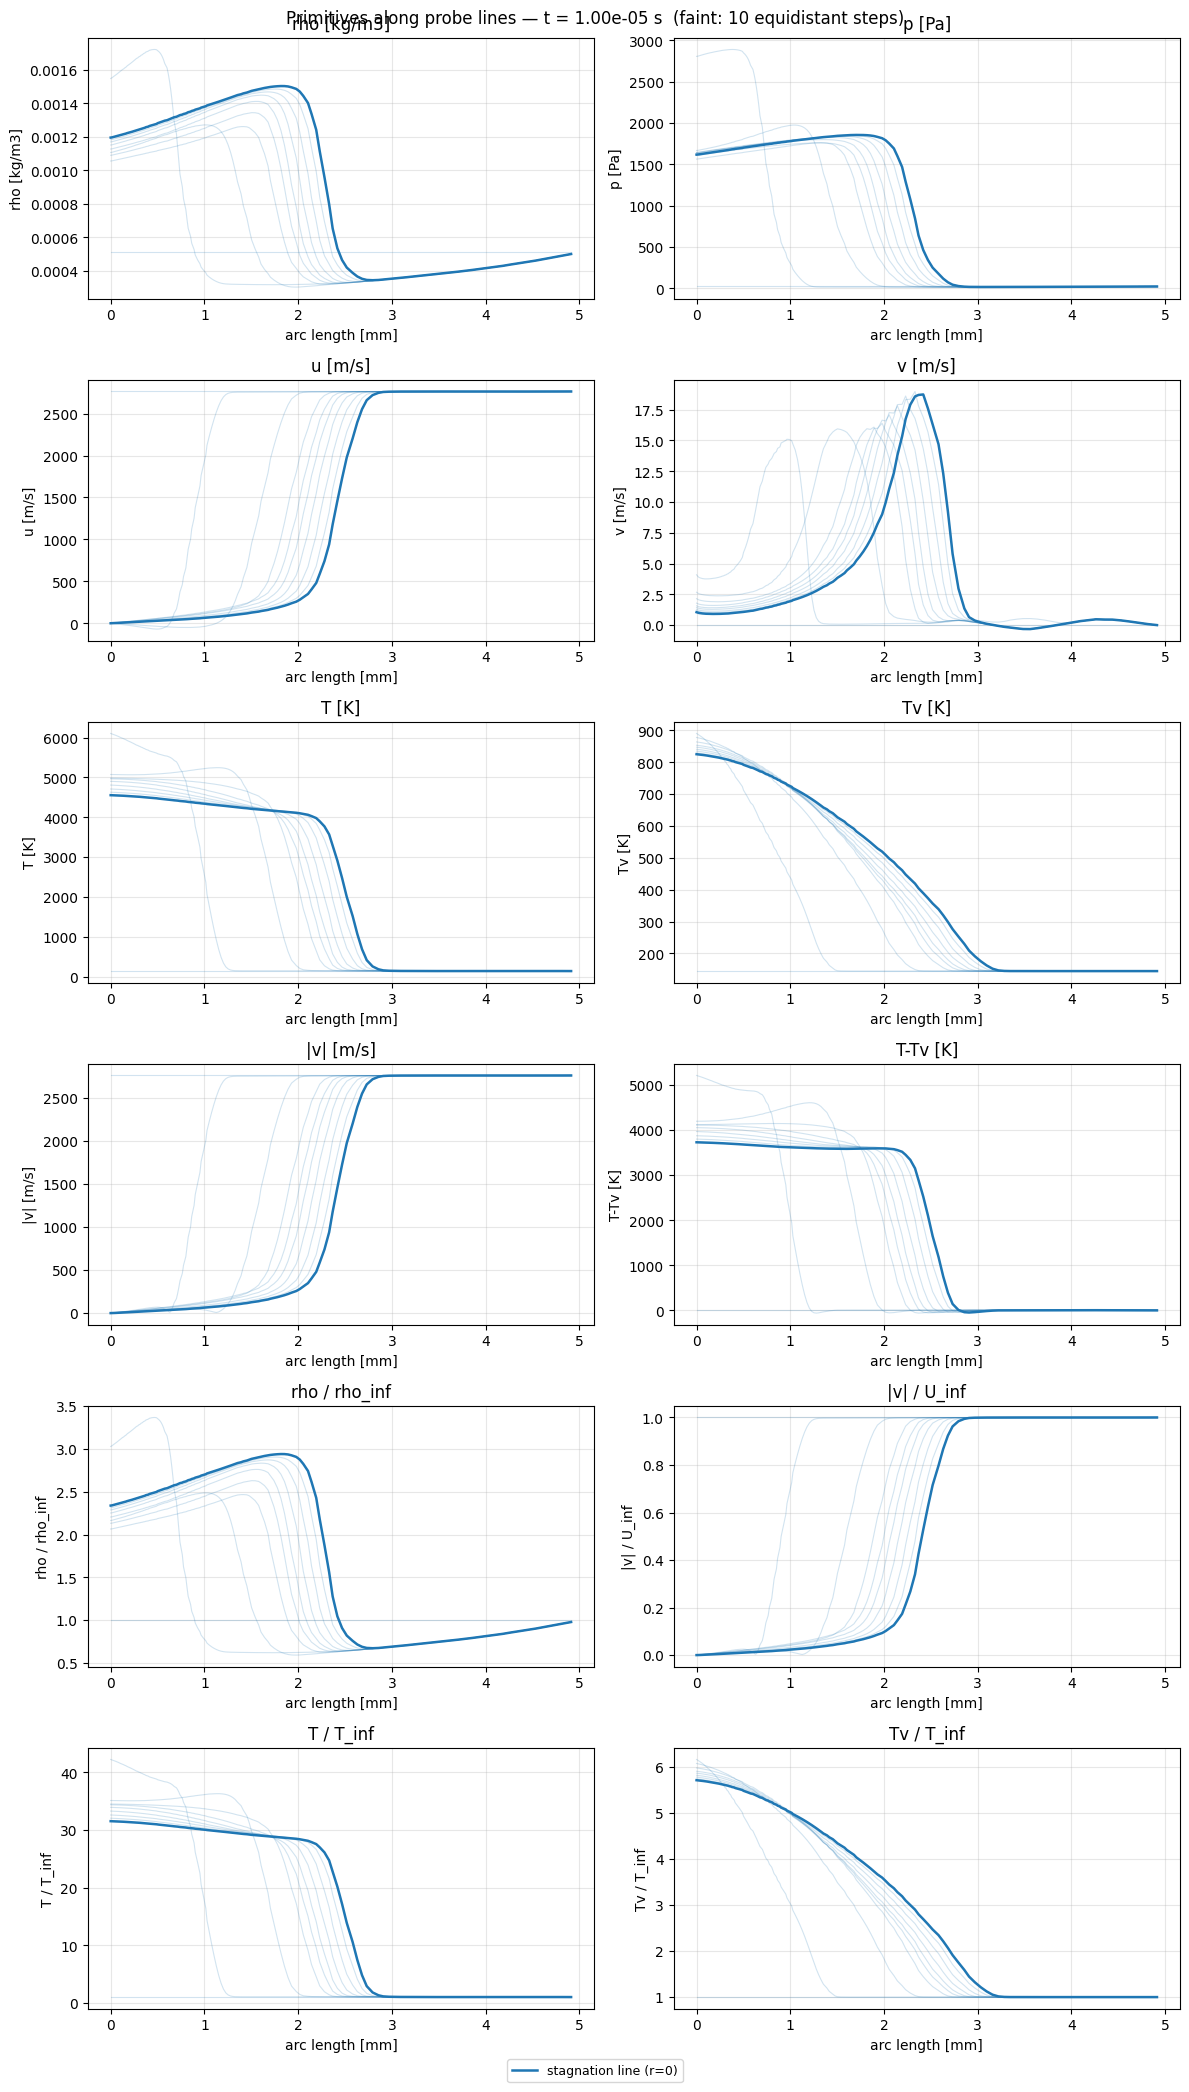

In [8]:
import matplotlib.pyplot as plt

# ── freestream reference values ────────────────────────────────────────────────
T_inf = 144.4
p_inf = 21.9139
rho_inf = 5.113e-4
U_inf = 2764.5
Tv_inf = T_inf
# ──────────────────────────────────────────────────────────────────────────────

PLOT_STEP = -1

n_steps = u_all.shape[0]
main_idx = n_steps + PLOT_STEP if PLOT_STEP < 0 else PLOT_STEP
bg_steps = np.linspace(0, n_steps - 1, min(10, n_steps), dtype=int).tolist()


def get_fields(i):
    _u = np.array(u_all[i])
    _v = np.array(v_all[i])
    _T = np.array(T_all[i])
    _Tv = np.array(Tv_all[i])
    _rho = np.array(rho_all[i])
    _p = np.array(p_all[i])
    _umag = np.sqrt(_u**2 + _v**2)
    return {
        "rho [kg/m3]": _rho,
        "p [Pa]": _p,
        "u [m/s]": _u,
        "v [m/s]": _v,
        "T [K]": _T,
        "Tv [K]": _Tv,
        "|v| [m/s]": _umag,
        "T-Tv [K]": _T - _Tv,
        "rho / rho_inf": _rho / rho_inf,
        "|v| / U_inf": _umag / U_inf,
        "T / T_inf": _T / T_inf,
        "Tv / T_inf": _Tv / Tv_inf,
    }


main_fields = get_fields(main_idx)
line_colors = [plt.cm.tab10(i) for i in range(len(probe_lines))]

n_cols, n_rows = 2, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows))
axes_flat = axes.flatten()

# pre-compute cell indices once per probe line
line_samples = [sample_line(cc, ld["p0"], ld["p1"]) for ld in probe_lines]

for ax, name in zip(axes_flat, main_fields):
    # faint convergence lines
    for si in bg_steps:
        fields = get_fields(si)
        for (cells, arcs), color in zip(line_samples, line_colors):
            ax.plot(arcs * 1e3, fields[name][cells], color=color, lw=0.8, alpha=0.2)
    # highlighted main step
    for (cells, arcs), line_def, color in zip(line_samples, probe_lines, line_colors):
        ax.plot(
            arcs * 1e3,
            main_fields[name][cells],
            label=line_def["label"],
            color=color,
            lw=1.8,
        )
    ax.set_xlabel("arc length [mm]")
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.grid(True, alpha=0.3)

for ax in axes_flat[len(main_fields) :]:
    ax.set_visible(False)

handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(probe_lines),
    bbox_to_anchor=(0.5, -0.01),
    fontsize=9,
)

t_val = float(t_hist[main_idx])
fig.suptitle(
    f"Primitives along probe lines — t = {t_val:.2e} s  "
    f"(faint: {len(bg_steps)} equidistant steps)",
    fontsize=12,
)
plt.tight_layout()
plt.show()